In [12]:
import igraph
import networkx as nx
from statistics import mean, median, stdev
import matplotlib.pyplot as plt
import random
import statsmodels.stats.api as sms
import numpy as np
import scipy
from weighted_multifractal_graph import generate_adj # file .py available in the repository

# Utility functions

In [3]:
# Convert a NetworkX graph to an igraph graph, handling isolated nodes.
# - graph: NetworkX graph to be converted.
# Returns an igraph graph with simplified edges (no duplicates or self-loops).
def convert_to_igraph(graph):
    edge_list = graph.edges(data='weight', default=1.0)

    # Create igraph graph with weights
    G_igraph = igraph.Graph.TupleList(edge_list, weights=weights, directed=False)

    # Add isolated nodes to the igraph graph
    isolated_nodes = set(graph.nodes()) - set(G_igraph.vs["name"])
    G_igraph.add_vertices(list(isolated_nodes))
    return G_igraph # G_igraph.simplify() to make it unweighted

# Check various features of an igraph graph and return the results.
# - graph: igraph graph object to be examined.
# Returns a tuple containing:
# - is_directed: True if the graph is directed, False otherwise.
# - is_connected: True if the graph is connected, False otherwise.
# - is_weighted: True if the graph is weighted, False otherwise.
# - num_nodes: Number of nodes in the graph.
# - num_edges: Number of edges in the graph.
def check_graph_features(graph):
    is_directed = graph.is_directed()
    is_connected = graph.is_connected()
    is_weighted = graph.is_weighted()
    num_nodes = graph.vcount()
    num_edges = graph.ecount()
    return is_directed, is_connected, is_weighted, num_nodes, num_edges

# Function to get NetworkX graph features
def get_networkx_graph_features(graph):
    is_directed = nx.is_directed(graph)
    is_connected = nx.is_weakly_connected(graph) if is_directed else nx.is_connected(graph)
    is_weighted = any("weight" in graph[u][v] for u, v in graph.edges())
    num_nodes = len(graph.nodes())
    num_edges = len(graph.edges())
    return is_directed, is_connected, is_weighted, num_nodes, num_edges

# Load dataset

In [4]:
brain_path = 'rattus.norvegicus_brain_2.graphml'

# Load the GraphML file
G = nx.read_graphml(brain_path).to_undirected()

print("Graph total number of nodes: ", G.number_of_nodes())
print("Graph total number of edges: ", G.number_of_edges())

degrees = dict(G.degree())
mean_degree = mean(degrees.values())

Graph total number of nodes:  503
Graph total number of edges:  24656


# General node statistics

In [5]:
node_with_highest_degree = max(degrees, key=degrees.get)
print(f"Node with highest degree {node_with_highest_degree} has degree {degrees[node_with_highest_degree]}")
node_with_lowest_degree = min(degrees, key=degrees.get)
print(f"Node with lowest degree {node_with_lowest_degree} has degree {degrees[node_with_lowest_degree]}")
mean_degree = mean(degrees.values())
print(f"Mean degree: {mean_degree}")

Node with highest degree n281 has degree 499
Node with lowest degree n209 has degree 0
Mean degree: 98.03578528827038


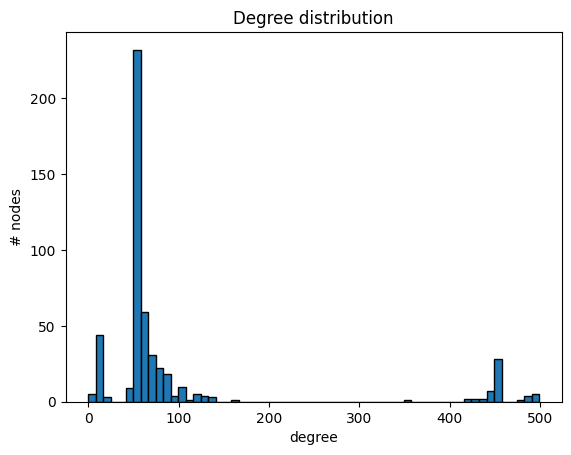

In [6]:
frequency = {}
for number in degrees.values():
    if number in frequency:
        frequency[number] += 1
    else:
        frequency[number] = 1

plt.hist(degrees.values(), bins=60, edgecolor='black')
plt.xlabel('degree')
plt.ylabel('# nodes')
plt.title('Degree distribution')
plt.show()

# Edge weights analysis

Highest weight 9.0
Highest weight 1.0
Mean weight: 1.6629218040233615


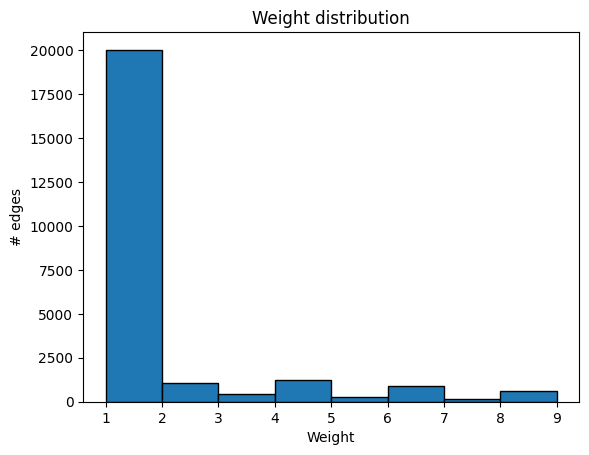

In [7]:
edges = dict(G.edges())

weights = []
for key, value in edges.items():
  weights.append(value['weight'])

highest_weight = max(weights)
print(f"Highest weight {highest_weight}")
lowest_weight = min(weights)
print(f"Highest weight {lowest_weight}")
mean_weight = mean(weights)
print(f"Mean weight: {mean_weight}")

plt.hist(weights, bins=8, edgecolor='black')
plt.xlabel('Weight')
plt.ylabel('# edges')
plt.title('Weight distribution')
plt.show()

# Metrics of the imported connectome

In [8]:
transitivity = nx.transitivity(G) # Global clustering coefficient.
avg_loc = mean(nx.clustering(G).values())
squared_loc = {key: value**2 for key, value in nx.clustering(G).items()}
avg_loc2 = mean(squared_loc.values())
avg_clos = mean(nx.closeness_centrality(G, distance='weight').values())
avg_betw = mean(nx.betweenness_centrality(G, weight=True).values())
avg_degree = mean(dict(G.degree()).values())
graph_igraph = convert_to_igraph(G)
motifs_result3 = graph_igraph.motifs_randesu(size=3)
motifs_result4 = graph_igraph.motifs_randesu(size=4)

print("Graph level features")
print(f"Global clustering coefficient: {transitivity}")
print("Node level features")
print(f"Mean local clustering coefficient: {avg_loc}")
print(f"Mean squared local clustering coefficient: {avg_loc2}")
print(f"Mean closeness centrality: {avg_clos}")
print(f"Mean betweeness centrality: {avg_betw}")
print(f"Mean degree centrality: {avg_degree}")
print(f"Graphlet size 3 count, type 2: {motifs_result3[2]}")
print(f"Graphlet size 3 count, type 3: {motifs_result3[3]}")
print(f"Graphlet size 4 count, type 4: {motifs_result4[4]}")
print(f"Graphlet size 4 count, type 6: {motifs_result4[6]}")
print(f"Graphlet size 4 count, type 7: {motifs_result4[7]}")
print(f"Graphlet size 4 count, type 8: {motifs_result4[8]}")
print(f"Graphlet size 4 count, type 9: {motifs_result4[9]}")
print(f"Graphlet size 4 count, type 10: {motifs_result4[10]}")

Graph level features
Global clustering coefficient: 0.32200264950245183
Node level features
Mean local clustering coefficient: 0.8889921151802328
Mean squared local clustering coefficient: 0.8466267771917872
Mean closeness centrality: 0.5489110425227516
Mean betweeness centrality: 0.0015998829331586553
Mean degree centrality: 98.03578528827038
Graphlet size 3 count, type 2: 4201814
Graphlet size 3 count, type 3: 665192
Graphlet size 4 count, type 4: 524294022
Graphlet size 4 count, type 6: 2642274
Graphlet size 4 count, type 7: 55320300
Graphlet size 4 count, type 8: 203949
Graphlet size 4 count, type 9: 100834763
Graphlet size 4 count, type 10: 12107594


# Metrics calculation function

In [26]:
# Function to compute all the metrics
# graph_generator_func: function used to generate the graph
# params_gen: arguments to pass to the generation function

def compute_metrics(graph_generator_func, params_gen):
  list_trans = []
  list_loc_clust_coeff = []
  list_avg_loc2 = []
  list_clos_centr = []
  list_betw_centr = []
  list_degree_centr = []
  list_graphlet_count3 = []
  list_graphlet_count4 = []

  N = 100 # Number of random graph to be generated

  for n in range(0,N) :
    print(f"Iteration {n}")
    # Graph generation
    if graph_generator_func.__name__ != 'weighted_multifractal' :
        params_gen['seed'] = random.randint(1, 10000) # Add kwargs with variable seed
      
    graph = graph_generator_func(**params_gen)

    # number of edges:
    # print("Number of edges: ", graph.number_of_edges())
    # print("Number of nodes: ", graph.number_of_nodes())

    # Compute global clustering coefficient
    list_trans.append(nx.transitivity(graph))

    # Compute mean, median, stdev of local clustering coefficients
    loc_clust_coeff = nx.clustering(graph).values()
    list_loc_clust_coeff.append([ mean(loc_clust_coeff), median(loc_clust_coeff), stdev(loc_clust_coeff) ])

    # Compute average squared local clustering coefficients
    loc_clust_coeff_2 = [value**2 for value in loc_clust_coeff]
    list_avg_loc2.append(mean(loc_clust_coeff_2))

    # Compute mean, median, stdev of closeness centrality
    clos_centr = nx.closeness_centrality(graph, distance='weight').values()
    list_clos_centr.append([ mean(clos_centr), median(clos_centr), stdev(clos_centr) ])

    # Compute mean, median, stdev of betweeness centrality
    betw_centr = nx.betweenness_centrality(graph, weight=True).values()
    list_betw_centr.append([ mean(betw_centr), median(betw_centr), stdev(betw_centr) ])

    # Compute mean, median, stdev of degree centrality
    degree_centr = dict(graph.degree()).values()
    list_degree_centr.append([ mean(degree_centr), median(degree_centr), stdev(degree_centr) ])

    # Compute graphlet count for size 3 and 4
    graph_igraph = convert_to_igraph(graph)
    motifs_result3 = graph_igraph.motifs_randesu(size=3)
    list_graphlet_count3.append(motifs_result3)
    motifs_result4 = graph_igraph.motifs_randesu(size=4)
    list_graphlet_count4.append(motifs_result4)

  # Compute mean and condidence interval of the metrics over the N generated graph
  avg_trans = mean(list_trans)
  conf_trans = sms.DescrStatsW(list_trans).tconfint_mean(alpha=0.05, alternative='two-sided' )


  avgs_loc = [sublist[0] for sublist in list_loc_clust_coeff]
  std_devs_loc = [sublist[2]**2 for sublist in list_loc_clust_coeff]
  avg_loc = mean(avgs_loc)
  std_dev_loc = np.sqrt(mean(std_devs_loc))
  conf_loc = sms.DescrStatsW(avgs_loc).tconfint_mean(alpha=0.05, alternative='two-sided' )

  avg_loc2 = mean(list_avg_loc2)
  conf_loc2 = sms.DescrStatsW(list_avg_loc2).tconfint_mean(alpha=0.05, alternative='two-sided' )

  avgs_clos = [sublist[0] for sublist in list_clos_centr]
  std_devs_clos = [sublist[2]**2 for sublist in list_clos_centr]
  std_dev_clos = np.sqrt(mean(std_devs_clos))
  avg_clos = mean(avgs_clos)
  conf_clos = sms.DescrStatsW(avgs_clos).tconfint_mean(alpha=0.05, alternative='two-sided' )

  avgs_betw = [sublist[0] for sublist in list_betw_centr]
  std_devs_betw= [sublist[2]**2 for sublist in list_betw_centr]
  std_dev_betw = np.sqrt(mean(std_devs_betw))
  avg_betw = mean(avgs_betw)
  conf_betw = sms.DescrStatsW(avgs_betw).tconfint_mean(alpha=0.05, alternative='two-sided' )

  avgs_degree = [sublist[0] for sublist in list_degree_centr]
  std_devs_degree= [sublist[2]**2 for sublist in list_degree_centr]
  std_dev_degree = np.sqrt(mean(std_devs_degree))
  avg_degree = mean(avgs_degree)
  conf_degree= sms.DescrStatsW(avgs_degree).tconfint_mean(alpha=0.05, alternative='two-sided' )

  count3_2 = [sublist[2] for sublist in list_graphlet_count3]
  avgs_count3_2 = mean(count3_2)
  conf_grap_3_2 = sms.DescrStatsW(count3_2).tconfint_mean(alpha=0.05, alternative='two-sided' )

  count3_3 = [sublist[3] for sublist in list_graphlet_count3]
  avgs_count3_3 = mean(count3_3)
  conf_grap_3_3 = sms.DescrStatsW(count3_3).tconfint_mean(alpha=0.05, alternative='two-sided' )

  count4_4 = [sublist[4] for sublist in list_graphlet_count4]
  avgs_count4_4 = mean(count4_4)
  conf_grap_4_4 = sms.DescrStatsW(count4_4).tconfint_mean(alpha=0.05, alternative='two-sided' )

  count4_6 = [sublist[6] for sublist in list_graphlet_count4]
  avgs_count4_6 = mean(count4_6)
  conf_grap_4_6 = sms.DescrStatsW(count4_6).tconfint_mean(alpha=0.05, alternative='two-sided' )

  count4_7 = [sublist[7] for sublist in list_graphlet_count4]
  avgs_count4_7 = mean(count4_7)
  conf_grap_4_7 = sms.DescrStatsW(count4_7).tconfint_mean(alpha=0.05, alternative='two-sided' )

  count4_8 = [sublist[8] for sublist in list_graphlet_count4]
  avgs_count4_8 = mean(count4_8)
  conf_grap_4_8 = sms.DescrStatsW(count4_8).tconfint_mean(alpha=0.05, alternative='two-sided' )

  count4_9 = [sublist[9] for sublist in list_graphlet_count4]
  avgs_count4_9 = mean(count4_9)
  conf_grap_4_9 = sms.DescrStatsW(count4_9).tconfint_mean(alpha=0.05, alternative='two-sided' )

  count4_10 = [sublist[10] for sublist in list_graphlet_count4]
  avgs_count4_10 = mean(count4_10)
  conf_grap_4_10 = sms.DescrStatsW(count4_10).tconfint_mean(alpha=0.05, alternative='two-sided')

  print("Writing file")
  with open('calculated_metrics/metrics.txt', 'a') as file:
    print(f"Graph level features - {graph_generator_func.__name__}", file=file)
    print(f"Global clustering coefficient. Mean {avg_trans} confidence: {conf_trans}", file=file)
    print("Node level features", file=file)
    print(f"Mean local clustering coefficient. Mean {avg_loc} confidence: {conf_loc} stddev: {std_dev_loc}", file=file)
    print(f"Mean squared local clustering coefficient. Mean {avg_loc2} confidence: {conf_loc2}", file=file)
    print(f"Mean closeness centrality. Mean {avg_clos} confidence: {conf_clos} stddev: {std_dev_clos}", file=file)
    print(f"Mean betweeness centrality. Mean {avg_betw} confidence: {conf_betw} stddev: {std_dev_betw}", file=file)
    print(f"Mean degree centrality. Mean {avg_degree} confidence: {conf_degree} stddev: {std_dev_degree}", file=file)
    print(f"Mean graphlet count size 3, type 2. Mean {avgs_count3_2} confidence: {conf_grap_3_2}", file=file)
    print(f"Mean graphlet count size 3, type 3. Mean {avgs_count3_3} confidence: {conf_grap_3_3}", file=file)
    print(f"Mean graphlet count size 4, type 4. Mean {avgs_count4_4} confidence: {conf_grap_4_4}", file=file)
    print(f"Mean graphlet count size 4, type 6. Mean {avgs_count4_6} confidence: {conf_grap_4_6}", file=file)
    print(f"Mean graphlet count size 4, type 7. Mean {avgs_count4_7} confidence: {conf_grap_4_7}", file=file)
    print(f"Mean graphlet count size 4, type 8. Mean {avgs_count4_8} confidence: {conf_grap_4_8}", file=file)
    print(f"Mean graphlet count size 4, type 9. Mean {avgs_count4_9} confidence: {conf_grap_4_9}", file=file)
    print(f"Mean graphlet count size 4, type 10. Mean {avgs_count4_10} confidence: {conf_grap_4_10}", file=file)
    print("\n", file=file)


# Random regular graph
A d-regular graph has all n vertices of degree d and n × d must be even.
The resulting graph has no self-loops or parallel edges


In [25]:
# GENERATION PARAMETERS
# - degree d of each node
# - number of nodes n
compute_metrics(nx.random_regular_graph, {'d': int(round(mean_degree)), 'n': G.number_of_nodes()})

Iteration 0
Iteration 1
Iteration 2
Writing file


# Barabasi Albert graph

A graph of n nodes is grown by attaching new nodes each with m edges that are preferentially attached to existing nodes with high degree.

In [ ]:
# GENERATION PARAMETERS
# - m edges of every new node attached
# - number of nodes n
compute_metrics(nx.barabasi_albert_graph, {'m': int(round(mean_degree)), 'n': G.number_of_nodes()})

# Erdős-Rényi graph
The $G_{n,p}$ model chooses each of the possible edges with probability p

In [ ]:
# GENERATION PARAMETERS
# - number of nodes n
# - probability p of new edge:
# p must be so that the expected number of edges is equal to the number of edges in the connectome
prob = G.number_of_edges() * 2 / (G.number_of_nodes() * (G.number_of_nodes() - 1))
compute_metrics(nx.erdos_renyi_graph, {'n': G.number_of_nodes(), 'p': prob})

# Watts–Strogatz

The Watts–Strogatz model is a random graph generation model that produces graphs with small-world properties, including short average path lengths and high clustering

In [ ]:
# GENERATION PARAMETERS
# - number of nodes n
# - k nearest neighbors
# - probability p of rewiring each edge:
# k must resemble the mean degree of the connectome, meanwhile for the choice
# of p we did not found relevant changes between the results
k = round(mean_degree)
prob = 0.85

compute_metrics(nx.watts_strogatz_graph, {'n': G.number_of_nodes(), 'k': k ,'p': prob})

# Weighted Multifractal Graph

Function to generate a Weighted Multifractal graph in networkx format

In [19]:
def weighted_multifractal(PK, LK, LKcum, N, isDirected, isBinary):
    adj, class_array = generate_adj(PK, LK, LKcum, N, isDirected, isBinary)
    graph = nx.from_numpy_array(adj)
    return graph

In [23]:
# GENERATION PARAMETERS
# - PK probability for the edge generation
# - LK probability for the node generation
# - LKcum probability distribution for the node generation
# - N number of nodes in the generated graph
# - isDirected and isBinary are flags for the resulting graph type
# Both PK and LK parameters are estimated in $filename_to_be_added

# Load PK and LK estimated using matlab code
modelParaPK = np.loadtxt('Matlab/EM_matlab_result/modelParaPK.csv', delimiter=',')
modelParaLK = np.loadtxt('Matlab/EM_matlab_result/modelParaLK.csv', delimiter=',')

# Load PK and LK estimated using our py code
# modelParaPK = np.loadtxt('EM_py_results/modelParaPK.csv', delimiter=';')
# modelParaLK = np.loadtxt('EM_py_results/modelParaLK.csv', delimiter=';')

compute_metrics(weighted_multifractal, { 'PK' : modelParaPK, 'LK' : modelParaLK, 'LKcum' : np.cumsum(modelParaLK),
                                        'N' : G.number_of_nodes(), 'isDirected' : 0, 'isBinary' : 0 })


Iteration 0
Iteration 1
Iteration 2
Writing file
